In [160]:
%matplotlib inline

# Version 1 du modèle prédictif

On commence par importer les données dont on aura besoin

In [171]:
import pandas as pd

In [172]:
league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0)

On retire les colonnes suivantes : B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA car je ne sais pas à quoi elles correspondent, il n'y a aucune indication

In [173]:
match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

Dans cette version, on ne va pas s'interesser aux joeurs, on va rester au niveau de granularité supérieur, cad les équipes

In [174]:
match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

Enfin, on ne va pas non plus encore s'interesser aux corner, possession, tirs cadrés, etc. On les supprime aussi

In [175]:
match.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'],
           axis=1, inplace=True)

Enfin, on va rajouter les colonnes contenant le nom complet des équipes afin de les identifier plus facilement

In [176]:
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

In [177]:
match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

In [179]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,KRC Genk,Beerschot AC
1,483,1,1,2009/2010,5,2009-08-30 00:00:00,665353,9987,9993,1,1,KRC Genk,Beerschot AC
2,524,1,1,2010/2011,1,2010-08-01 00:00:00,838476,9987,9993,2,1,KRC Genk,Beerschot AC
3,759,1,1,2011/2012,1,2011-07-30 00:00:00,1032694,9987,9993,3,1,KRC Genk,Beerschot AC
4,1014,1,1,2012/2013,11,2012-10-20 00:00:00,1224064,9987,9993,3,0,KRC Genk,Beerschot AC


On va maintenant se limiter à la ligue 1 française dans un premier temps

In [182]:
match_ligue_1 = match[match.league_id == 4769]
num_teams = len(match_ligue_1.away_team_api_id.unique())
print(num_teams)

35


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [183]:
teams = match_ligue_1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [184]:
teams.head()

,team,i
0,AJ Auxerre,0
1,Girondins de Bordeaux,1
2,Le Havre AC,2
3,Le Mans FC,3
4,Olympique Lyonnais,4


In [187]:
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [188]:
match_ligue_1.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,i_home,i_away,i_home,i_away
0,4769,4769,4769,2008/2009,1,2008-08-09 00:00:00,483129,8583,9830,2,1,AJ Auxerre,FC Nantes,NaN,NaN,0,30
1,4990,4769,4769,2008/2009,3,2008-08-24 00:00:00,483150,9827,9830,2,0,Girondins de Bordeaux,FC Nantes,NaN,NaN,1,30
2,6710,4769,4769,2013/2014,13,2013-11-10 00:00:00,1468280,9827,9830,0,3,Girondins de Bordeaux,FC Nantes,NaN,NaN,1,30
3,7339,4769,4769,2014/2015,36,2015-05-09 00:00:00,1710047,9827,9830,2,1,Girondins de Bordeaux,FC Nantes,NaN,NaN,1,30
4,7750,4769,4769,2015/2016,4,2015-08-30 00:00:00,1989809,9827,9830,2,0,Girondins de Bordeaux,FC Nantes,NaN,NaN,1,30


In [74]:
observed_home_goals = match_ligue_1.home_team_goal.values
observed_away_goals = match_ligue_1.away_team_goal.values

home_team = match_ligue_1.i_home.values
away_team = match_ligue_1.i_away.values

On décrit notre modélisation

In [207]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # team-specific model parameters
    attaque = pm.Normal("attaque", mu=0, sd=1, shape=num_teams)
    defense = pm.Normal("defense", mu=0, sd=1, shape=num_teams)

    home_theta  = pm.math.exp(attaque[home_team] - defense[away_team])
    away_theta  = pm.math.exp(attaque[away_team] - defense[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

In [208]:
with model:
    trace = pm.sample(2000, n_init=70000)

    pm.traceplot(trace)

Assigned NUTS to attaque
Assigned NUTS to defense

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

KeyError: 'defense_log_'

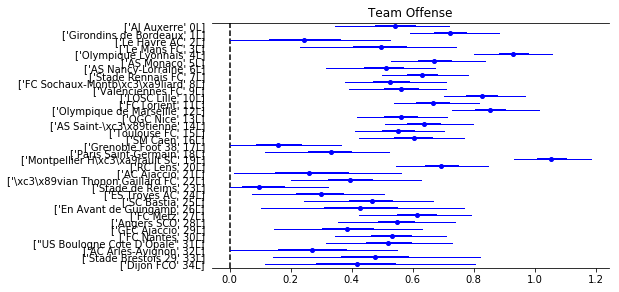

In [189]:
pm.forestplot(trace, varnames=['attaque'], ylabels=teams.values, main="Team Offense")

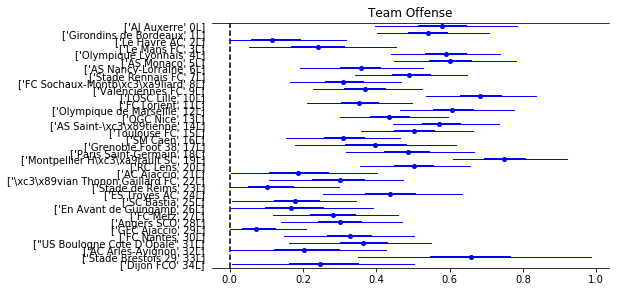

In [193]:
pm.forestplot(trace, varnames=['defense'], ylabels=teams.values, main="Team Offense")

Les résultats sont cohérents, passons à la prédiction d'un nouveau match

# Prédiction de l'issue d'un match

In [206]:
trace

<MultiTrace: 1 chains, 50 iterations, 4 variables>